In [1]:
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import copy
import multiprocessing as mp
import math
import time
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs
import random
from scipy.linalg import fractional_matrix_power

if 'COLAB_TPU_ADDR' not in os.environ:
  print('TPU Inactive')
else:
  print('TPU Active')

TPU Inactive


In [2]:
# Graph

N = 4
Adj = [[0,1,0,1],[1,0,1,0],[0,1,0,1],[1,0,1,0]]

In [18]:
# Utility functions

def print_details():
  print(f'\nNo. of node = {N}')
  print("Adjacency Matrix : ")
  print(Adj)

def divide_data(tot,N):
  np.random.seed(1)
  data_per_node = []
  start = 0
  print('\n')
  for i in range(0,N-1):
    alloted = 1+np.random.randint(tot-(N-i-1))
    print(f'No. of data alloted to node {i+1} = {alloted}')
    data_per_node.append([start,start+alloted-1])
    tot -= alloted
    start += alloted
  data_per_node.append([start,start+tot-1])
  print(f'No. of data alloted to node {N} = {tot}')
  return data_per_node

def predict(val):
  if val >= 0:
    return 1
  else:
    return -1

def calculate_consensus_error(N,W,B):
  W_avg_now = copy.deepcopy(W[0])
  B_avg_now = copy.deepcopy(B[0])
  for i in range(1,N):
    W_avg_now += W[i]
    B_avg_now += B[i]
  W_avg_now /= N
  B_avg_now /= N
  consensus_error = 0
  for i in range(N):
    temp = W[i]-W_avg_now
    consensus_error += np.dot(temp.T,temp)
    consensus_error += (B[i]-B_avg_now)**2
  consensus_error **= 0.5
  return np.log(consensus_error+(1e-300))

def get_avg(N,W,B):
  W_avg_now = copy.deepcopy(W[0])
  B_avg_now = copy.deepcopy(B[0])
  for i in range(1,N):
    W_avg_now += W[i]
    B_avg_now += B[i]
  W_avg_now /= N
  B_avg_now /= N
  return W_avg_now,B_avg_now

def calculate_loss(N,W,B,dataX,dataY,c,lmbd,kappa):
  loss = 0
  lmbd_times_kappa = lmbd*kappa
  tot = 0
  for i in range(N):
    if lmbd == -1:
      loss += (c/2)*np.dot(W[i].T,W[i])*len(dataX[i])
    for j in range(len(dataX[i])):
      tot += 1
      temp = (np.dot(W[i].T,dataX[i][j])+B[i])*dataY[i][j]
      loss += np.log(1+np.exp(-1*temp))
      if lmbd != -1:
        loss += max(temp-lmbd_times_kappa,0)
  return np.log(loss/tot+(1e-300))

def AdjMat2AdjList(AdjMat):
  AdjList = []
  for i in range(N):
    AdjList.append([])
    for j in range(N):
      if AdjMat[i][j]:
        AdjList[i].append(j)
  return AdjList

def get_accuracy_on_dataset(N,tot,W,B,dataX,dataY,algo_name,eps=1e-7):
  correct_count = 0
  for i in range(N):
    for j in range(len(dataX[i])):
      correct_count += (abs(dataY[i][j]-predict(B+np.dot(W.T,dataX[i][j]))) < eps)
  print(f'\naccuracy {algo_name} = {correct_count*100.0/tot}')
  return correct_count*100.0/tot

def from_numpy_to_list(X,y,N):
  dataX = []
  dataY = []
  tot = X.shape[0]
  for i in range(N):
    dataX.append([])
    dataY.append([])
    for j in range(i*tot//N,(i+1)*tot//N):
      dataX[i].append(X[j])
      dataY[i].append(y[j])
  return dataX,dataY

def print_aftermath(N,timee,W,B,loss):
  print(f'\nTime taken = {timee}')
  for i in range(N):
    print(f'\nW[{i}] = {W[i]} | B[{i}] = {B[i]}')
  W_avg, B_avg = get_avg(N,W,B)
  print(f'\nW_average = {W_avg} | B_average = {B_avg}')
  print(f'\nFinal Loss = {loss}')

def project_to_box(w,b,lmbd,M):
  for i in range(M):
    if w[i] > lmbd:
      w[i] = lmbd
    elif w[i] < lmbd:
      w[i] = -lmbd
  if b > lmbd:
    b = lmbd
  elif b < lmbd:
    b = -lmbd
  return w,b

def plot_W_and_B(N,M,W_list,B_list):
  iter = len(W_list)
  per_node = []
  for i in range(N):
    per_node.append([])
    for j in range(M+1):
      per_node[i].append([])
  for i in range(iter):
    for j in range(N):
      for k in range(M):
        per_node[j][k].append(W_list[i][j][k])
      per_node[j][M].append(B_list[i][j])
  for j in range(M+1): 
    for i in range(N):
      plt.plot(per_node[i][j],label=f'Node {i+1}')
    titlee = f'W[{j}]'
    if j == M:
      titlee = f'B'
    plt.title(titlee)
    plt.ylabel('Iteration')
    plt.legend()
    plt.show()

def grad(i,W,B,dataX,dataY,c_logistic,lmbd=-1,kappa=-1):
  grad_W = 0
  lmbd_times_kappa = lmbd*kappa
  if lmbd == -1:
    grad_W = c_logistic*W[i]*len(dataX[i])
  grad_B = 0
  for j in range(len(dataX[i])):
    temp1 = dataY[i][j]*(np.dot(dataX[i][j].T,W[i])+B[i])
    temp = np.exp(-1*temp1)
    grad_W -= temp*dataY[i][j]*dataX[i][j]/(1+temp)
    grad_B -= temp*dataY[i][j]/(1+temp)
    if lmbd != -1:
      if temp1 > lmbd_times_kappa:
        grad_W += dataY[i][j]*dataX[i][j]
        grad_B += dataY[i][j]
  return grad_W, grad_B

In [19]:
# centralized logistic

def centralized_logistic(N,M,dataX,dataY,tot,c):
  w_central = cp.Variable(M)
  b_central = cp.Variable()
  cost = (c/2)*cp.square(cp.norm(w_central))*tot
  for i in range(0,N):
    for j in range(len(dataX[i])):
      cost += cp.logistic(-(w_central.T@dataX[i][j]+b_central)*dataY[i][j])
  prob = cp.Problem(cp.Minimize(cost))

  t1 = time.time()
  loss = prob.solve()
  t1 = time.time()-t1

  print(f'\nTime taken = {t1} sec')
  print(f'\nFinal loss = {np.log(loss/tot)}')
  print(f'\nw = {w_central.value}')
  print(f'\nb = {b_central.value}')

  return np.array(w_central.value),b_central.value,loss/tot

In [20]:
# centralized DRLR

def centralized_DRLR(N,M,tot,Adj,dataX,dataY,kappa=10,epsilon=1e-3):

  w = cp.Variable(M)
  b = cp.Variable()
  lmbd = cp.Variable()
  cost = lmbd*eps
  for i in range(N):
    for j in range(len(dataX[i])):
      cost += cp.logistic(-(w.T@dataX[i][j]+b)*dataY[i][j])/tot
      cost += cp.maximum((w.T@dataX[i][j]+b)*dataY[i][j]-lmbd*kappa,0)/tot
  constraint = [cp.norm(w,"inf")<=lmbd,cp.norm(b,"inf")<=lmbd]
  
  prob = cp.Problem(cp.Minimize(cost),constraint)
  t0 = time.time()
  result = prob.solve()
  t1 = time.time() - t0

  print(f'\nTime taken = {t1} sec')
  print(f'\nFinal loss = {np.log(result)}')
  print(f'\nOptimal Lambda = {lmbd.value}')
  print(f'\nw = {w.value}')
  print(f'\nb = {b.value}')

  return np.array(w.value),b.value,[],[]

In [21]:
# distADMM1

def distADMM1(N,M,iter,Adj,dataX,dataY,beta,c,lmbd=-1,kappa=-1):
  np.random.seed(1)
  loss_hist = []
  consensus_error_hist = []
  P = {}
  S = {}
  lamda_W = []
  lamda_B = []
  W = []
  B = []
  W_avg = []
  B_avg = []
  W_new = []
  lamda_W_new = []
  B_new = []
  lamda_B_new = []
  W_list = []
  B_list = []
  lmbd_times_kappa = lmbd*kappa
  for i in range(0,N):
    P[i] = []
    S[i] = []
    lamda_W.append([])
    lamda_B.append([])
    lamda_W_new.append([])
    lamda_B_new.append([])
    for i1 in range(0,N):
      lamda_W[i].append(np.random.randn(M))
      lamda_B[i].append(np.random.randn())
      lamda_W_new[i].append(np.array(M))
      lamda_B_new[i].append(0)
    W.append(np.random.randn(M)) # value at each node
    B.append(np.random.randn())
    W_avg.append(np.random.randn(M)) 
    B_avg.append(np.random.randn())
    W_new.append(np.array(M)) 
    B_new.append(0)
  for i in range(0,N):
    for j in range(i+1,N):
      if Adj[i][j]:
        P[j].append(i)
        S[i].append(j)

  t1 = time.time()
  for k in range(0,iter):
    print(f'Iter {k+1}')
    for i in range(0,N):
      w = cp.Variable(M)
      b = cp.Variable()
      cost = 0
      if lmbd == -1:
        cost += (c/2)*cp.square(cp.norm(w))*len(dataX[i])
      for j in range(len(dataX[i])):
        cost += cp.logistic(-(w.T@dataX[i][j]+b)*dataY[i][j])
        if lmbd != -1:
          cost += cp.maximum((w.T@dataX[i][j]+b)*dataY[i][j]-lmbd_times_kappa,0)
      for j in P[i]:
        cost += beta*0.5*cp.sum_squares(w-(W_new[j]-(1/beta)*lamda_W[j][i]))
        cost += beta*0.5*cp.sum_squares(b-(B_new[j]-(1/beta)*lamda_B[j][i]))
      for j in S[i]:
        cost += beta*0.5*cp.sum_squares(w-(W[j]+(1/beta)*lamda_W[i][j]))
        cost += beta*0.5*cp.sum_squares(b-(B[j]+(1/beta)*lamda_B[i][j]))
      
      constraint = []
      if lmbd != -1:
        constraint = [cp.norm(w,"inf")<=lmbd,cp.norm(b,"inf")<=lmbd]
      prob = cp.Problem(cp.Minimize(cost),constraint)
      prob.solve()
      
      W_new[i] = np.array(w.value)
      B_new[i] = b.value
    for i in range(0,N):
      for j in P[i]:
        lamda_W_new[j][i] = lamda_W[j][i]-beta*(W_new[j]-W_new[i])
        lamda_B_new[j][i] = lamda_B[j][i]-beta*(B_new[j]-B_new[i])
    W = copy.deepcopy(W_new)
    lamda_W = copy.deepcopy(lamda_W_new)
    B = copy.deepcopy(B_new)
    lamda_B = copy.deepcopy(lamda_B_new)
    for i in range(0,N):
      W_avg[i] = (W_avg[i]*(k+1)+W[i])/(k+2)
      B_avg[i] = (B_avg[i]*(k+1)+B[i])/(k+2)
    W_list.append(copy.deepcopy(W_avg))
    B_list.append(copy.deepcopy(B_avg))
    loss_hist.append(calculate_loss(N,W_avg,B_avg,dataX,dataY,c,lmbd,kappa))
    consensus_error_hist.append(calculate_consensus_error(N,W_avg,B_avg))
    print(f'Loss = {loss_hist[-1]}    Consensus Error = {consensus_error_hist[-1]}')
  t1 = time.time()-t1
  print_aftermath(N,t1,W_avg,B_avg,loss_hist[-1])  
  return W_avg,B_avg,loss_hist,consensus_error_hist,W_list,B_list

In [22]:
# distADMM2

def distADMM2(N,M,iter,AdjMat,dataX,dataY,c_ADMM,c_logistic,lmbd=-1,kappa=-1):
  loss_hist = []
  consensus_error_hist = []
  AdjList = AdjMat2AdjList(AdjMat)
  W = []
  B = []
  alpha_W = []
  alpha_B = []
  W_list = []
  B_list = []
  lmbd_times_kappa = lmbd*kappa
  for i in range(N):
    W.append(np.zeros(M))
    alpha_W.append(np.zeros(M))
    B.append(0)
    alpha_B.append(0)
  W_new = copy.deepcopy(W)
  B_new = copy.deepcopy(B)
  tt1 = time.time()
  for k in range(iter):
    print(f'Iter {k+1}')
    for i in range(N):
      Ni = len(AdjList[i])
      w = cp.Variable(M)
      b = cp.Variable()
      cost = 0
      if lmbd == -1:
        cost += (c_logistic/2)*cp.square(cp.norm(w))*len(dataX[i])
      for j in range(len(dataX[i])):
        cost += cp.logistic(-(w.T@dataX[i][j]+b)*dataY[i][j])
        if lmbd != -1:
          cost += cp.maximum((w.T@dataX[i][j]+b)*dataY[i][j]-lmbd_times_kappa,0)
      cost += w.T@alpha_W[i]+b*alpha_B[i]
      cost += c_ADMM*Ni*cp.sum_squares(w)+c_ADMM*Ni*cp.sum_squares(b)
      cost -= c_ADMM*Ni*(w.T@W[i]+b*B[i])
      for j in AdjList[i]:
        cost -= c_ADMM*(w.T@W[j]+b*B[j])
      
      constraint = []
      if lmbd != -1:
        constraint = [cp.norm(w,"inf")<=lmbd,cp.norm(b,"inf")<=lmbd]
      prob = cp.Problem(cp.Minimize(cost),constraint)
      prob.solve()
      
      W_new[i] = np.array(w.value)
      B_new[i] = b.value
    W = copy.deepcopy(W_new)
    B = copy.deepcopy(B_new)
    for i in range(N):    
      Ni = len(AdjList[i])
      alpha_W[i] += c_ADMM*(Ni*W[i])
      alpha_B[i] += c_ADMM*(Ni*B[i])
      for j in AdjList[i]:
        alpha_W[i] -= c_ADMM*W[j]
        alpha_B[i] -= c_ADMM*B[j]
    W_list.append(copy.deepcopy(W))
    B_list.append(copy.deepcopy(B))
    loss_hist.append(calculate_loss(N,W,B,dataX,dataY,c_logistic,lmbd,kappa))
    consensus_error_hist.append(calculate_consensus_error(N,W,B))
    print(f'Loss = {loss_hist[-1]}    Consensus Error = {consensus_error_hist[-1]}')
  tt1 = time.time()-tt1
  print_aftermath(N,tt1,W,B,loss_hist[-1])  
  return W,B,loss_hist,consensus_error_hist,W_list,B_list

In [23]:
# DLM

def DLM(N,M,iter,AdjMat,dataX,dataY,rho,c,c_logistic,lmbd=-1,kappa=-1):
  loss_hist = []
  consensus_error_hist = []
  AdjList = AdjMat2AdjList(AdjMat)
  D = []
  for i in range(N):
    D.append(2*c*len(AdjList[i])+rho)
  W = []
  B = []
  W_new = []
  B_new = []
  phi_W = []
  phi_B = []
  W_list = []
  B_list = []
  for i in range(N):
    W.append(np.zeros(M))
    B.append(0)
    W_new.append(np.zeros(M))
    B_new.append(0)
    phi_W.append(np.zeros(M))
    phi_B.append(0)
  loss_hist.append(calculate_loss(N,W,B,dataX,dataY,c_logistic,lmbd,kappa))
  consensus_error_hist.append(calculate_consensus_error(N,W,B))
  tt1 = time.time()
  for k in range(iter):
    print(f'Iter {k+1}')
    W_new = copy.deepcopy(W)
    B_new = copy.deepcopy(B)
    for i in range(N):
      W_new[i] -= phi_W[i]/D[i]
      B_new[i] -= phi_B[i]/D[i]
      for j in AdjList[i]:
        W_new[i] -= c*(W[i]-W[j])/D[i]
        B_new[i] -= c*(B[i]-B[j])/D[i]
      grad_W, grad_B = grad(i,W,B,dataX,dataY,c_logistic,lmbd,kappa)
      W_new[i] -= grad_W/D[i]
      B_new[i] -= grad_B/D[i]
      # if lmbd != -1:
      #   W_new[i],B_new[i] = project_to_box(W_new[i],B_new[i],lmbd,M)
    W = copy.deepcopy(W_new)
    B = copy.deepcopy(B_new)
    for i in range(N):
      for j in AdjList[i]:
        phi_W[i] += c*(W[i]-W[j])
        phi_B[i] += c*(B[i]-B[j])
    W_list.append(copy.deepcopy(W))
    B_list.append(copy.deepcopy(B))
    loss_hist.append(calculate_loss(N,W,B,dataX,dataY,c_logistic,lmbd,kappa))
    consensus_error_hist.append(calculate_consensus_error(N,W,B))
    print(f'Loss = {loss_hist[-1]}    Consensus Error = {consensus_error_hist[-1]}')
  tt1 = time.time()-tt1
  print_aftermath(N,tt1,W,B,loss_hist[-1])  
  return W,B,loss_hist,consensus_error_hist,W_list,B_list

In [24]:
# DGT

def DGT(N,M,iter,Adj,dataX,dataY,gamma,c_logistic,lmbd=-1,kappa=-1):
  x = 1/3.125
  Adj = [
            [      x, 0.5-x/2,       0, 0.5-x/2],
            [0.5-x/2,       x, 0.5-x/2,       0],
            [      0, 0.5-x/2,       x, 0.5-x/2],
            [0.5-x/2,       0, 0.5-x/2,       x]
            ]
  loss_hist = []
  consensus_error_hist = []
  W = []
  B = []
  y_W = []
  y_B = []
  W_list = []
  B_list = []
  # for i in range(N):
  #   W.append(np.random.randn(M))
  #   B.append(np.random.randn())
  for i in range(N):
    W.append(np.zeros(M))
    B.append(0)
  for i in range(N):
    grad_W, grad_B = grad(i,W,B,dataX,dataY,c_logistic,lmbd,kappa)
    y_W.append(grad_W)
    y_B.append(grad_B)
  loss_hist.append(calculate_loss(N,W,B,dataX,dataY,c_logistic,lmbd,kappa))
  consensus_error_hist.append(calculate_consensus_error(N,W,B))
  tt1 = time.time()
  for k in range(iter):
    print(f'Iter {k+1}')
    W_new = []
    B_new = []
    y_W_new = []
    y_B_new = []
    for i in range(N):
      W_new.append(np.zeros(M))
      B_new.append(0)
      y_W_new.append(np.zeros(M))
      y_B_new.append(0)
    for i in range(N):
      W_new[i] -= gamma*y_W[i]
      B_new[i] -= gamma*y_B[i]
      for j in range(N):
        W_new[i] += Adj[i][j]*W[j]
        B_new[i] += Adj[i][j]*B[j]
      # if lmbd != -1:
      #   W_new[i],B_new[i] = project_to_box(W_new[i],B_new[i],lmbd,M)
    for i in range(N):
      grad_W_new, grad_B_new = grad(i,W_new,B_new,dataX,dataY,c_logistic,lmbd,kappa)
      grad_W, grad_B = grad(i,W,B,dataX,dataY,c_logistic,lmbd,kappa)
      y_W_new[i] += grad_W_new-grad_W
      y_B_new[i] += grad_B_new-grad_B
      for j in range(N):
        y_W_new[i] += Adj[i][j]*y_W[j]
        y_B_new[i] += Adj[i][j]*y_B[j]
    W = copy.deepcopy(W_new)
    B = copy.deepcopy(B_new)
    y_W = copy.deepcopy(y_W_new)
    y_B = copy.deepcopy(y_B_new)
    W_list.append(copy.deepcopy(W))
    B_list.append(copy.deepcopy(B))
    loss_hist.append(calculate_loss(N,W,B,dataX,dataY,c_logistic,lmbd,kappa))
    consensus_error_hist.append(calculate_consensus_error(N,W,B))
    print(f'Loss = {loss_hist[-1]}    Consensus Error = {consensus_error_hist[-1]}')
  tt1 = time.time()-tt1
  print_aftermath(N,tt1,W,B,loss_hist[-1])  
  return W,B,loss_hist,consensus_error_hist,W_list,B_list

In [25]:
# Banknote Authentication Dataset

df = pd.read_csv('data_banknote_authentication.txt')
# df = pd.concat([pd.Series(1, index = df.index, name = '00'), df], axis=1)
X = df.drop(df.columns[-1],axis=1)
y= df["0"]
y = y.replace(0,-1)
X = X.to_numpy()
y = y.to_numpy()

print_details()

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 1)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
M = X_train.shape[1]
tot = X_train.shape[0]
tot2 = X_test.shape[0]

print(f'\nTotal no. of data points = {tot}')
print(f'Dimension of data = {M}')

dataX, dataY = from_numpy_to_list(X_train,y_train,N)
dataX_test, dataY_test = from_numpy_to_list(X_test,y_test,1)

print(len(dataX),len(dataY),len(dataX_test),len(dataY_test))
for u in dataX:
  print(len(u))

eps = 0.000001


No. of node = 4
Adjacency Matrix : 
[[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0]]
(1096, 4) (275, 4) (1096,) (275,)

Total no. of data points = 1096
Dimension of data = 4
4 4 1 1
274
274
274
274


In [13]:
# calling centralized

w_central,b_central,loss_central = centralized_logistic(N,M,dataX,dataY,tot,c = 0)
loss_central = np.log((1e-300)+loss_central)

get_accuracy_on_dataset(N,tot,w_central,b_central,dataX,dataY,algo_name='train Centralized',eps=1e-7)
get_accuracy_on_dataset(1,tot2,w_central,b_central,dataX_test,dataY_test,algo_name='test Centralized',eps=1e-7)


Time taken = 8.025323390960693 sec

Final loss = -4.1638538726419805

w = [-8.14616858 -4.56176566 -5.65838486 -0.83780945]

b = 7.723962074728934

accuracy train Centralized = 98.9963503649635

accuracy test Centralized = 98.18181818181819


In [ ]:
# calling centralized DRLR

W_cent_drlr,b_cent_drlr,_,_ = centralized_DRLR(N,M,tot,Adj,dataX,dataY,kappa=10,epsilon=1e-3)

get_accuracy_on_dataset(N,tot,W_cent_drlr,b_cent_drlr,dataX,dataY,algo_name='train Centralized DRLR',eps=1e-7)
get_accuracy_on_dataset(1,tot2,W_cent_drlr,b_cent_drlr,dataX_test,dataY_test,algo_name='test Centralized DRLR',eps=1e-7)


Time taken = 16.21268081665039 sec

Final loss = -4.163325298256282

Optimal Lambda = 8.141107151139016

w = [-8.14108668 -4.55909486 -5.65494604 -0.83719926]

b = 7.719497135204715

accuracy train Centralized DRLR = 98.9963503649635

accuracy test Centralized DRLR = 98.18181818181819


In [ ]:
# calling ADMM 1

iter = 50
print(f'\nNo. of iterations = {iter}\n')
W_admm1,B_admm1,loss_hist_admm1,consensus_error_hist_admm1,W_list,B_list = distADMM1(N,M,iter,Adj,dataX,dataY,beta = 10,c = 1,lmbd=8.141107151139016,kappa=10)

plot_W_and_B(N,M,W_list,B_list)
algo_name = 'dist ADMM 1'
W_avg_admm1,B_avg_admm1 = get_avg(N,W_admm1,B_admm1)
get_accuracy_on_dataset(N,tot,W_avg_admm1,B_avg_admm1,dataX,dataY,algo_name=f'train {algo_name}',eps=1e-7)
get_accuracy_on_dataset(1,tot2,W_avg_admm1,B_avg_admm1,dataX_test,dataY_test,algo_name=f'test {algo_name}',eps=1e-7)

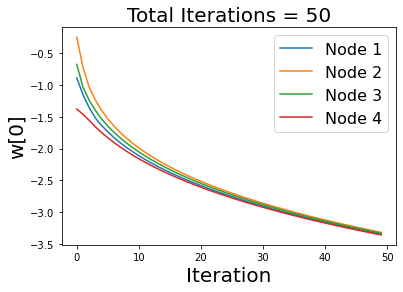

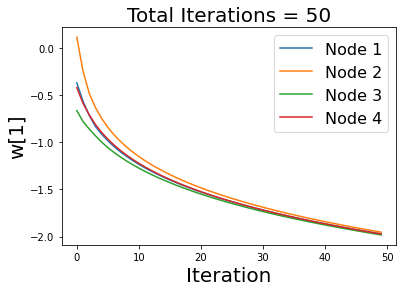

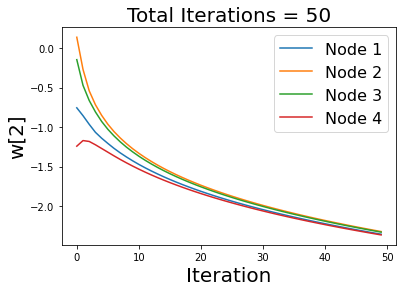

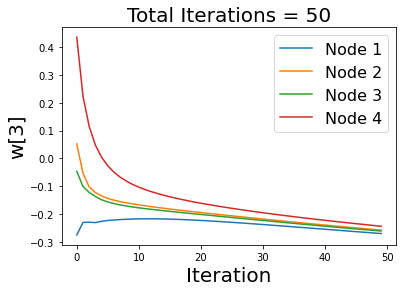

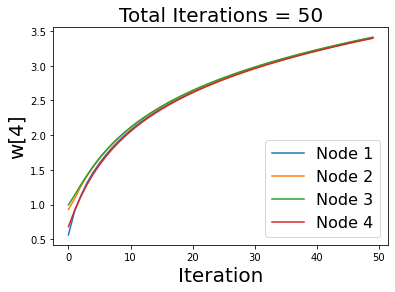

In [16]:
def plot_W_and_B2(N,M,W_list,B_list,le):
  iter = len(W_list)
  per_node = []
  for i in range(N):
    per_node.append([])
    for j in range(M+1):
      per_node[i].append([])
  for i in range(iter):
    for j in range(N):
      for k in range(M):
        per_node[j][k].append(W_list[i][j][k])
      per_node[j][M].append(B_list[i][j])
  for j in range(M+1): 
    for i in range(N):
      plt.plot(per_node[i][j],label=f'Node {i+1}')
    titlee = f'W[{j}]'
    if j == M:
      titlee = f'B'
#     plt.title(titlee)
    plt.xlabel('Iteration',fontsize=20)
    plt.ylabel(f'w[{j}]',fontsize=20)
    plt.title(f'Total Iterations = {le}',fontsize=20)
    plt.legend(fontsize=16)
    plt.savefig(f'{le} - W[{j}].jpg')
    plt.show()
    
le = 50
plot_W_and_B2(N,M,W_list[:le],B_list[:le],le)

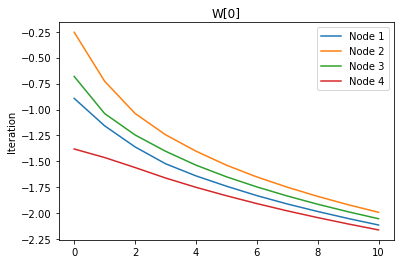

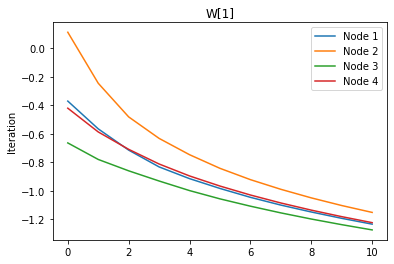

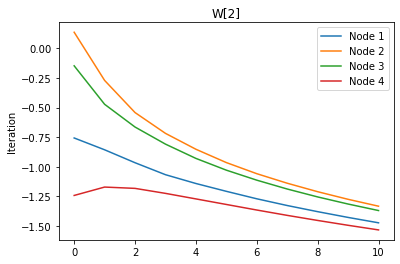

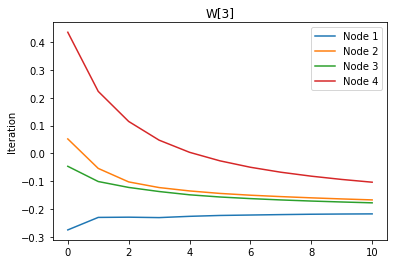

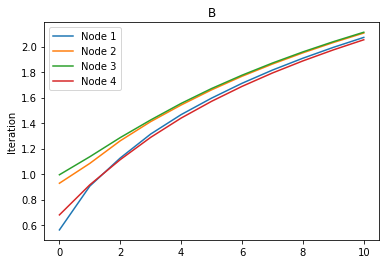

In [27]:
plot_W_and_B(N,M,W_list[:11],B_list[:11])

In [ ]:
# calling ADMM 2

iter = 5
print(f'\nNo. of iterations = {iter}\n')
W_admm2,B_admm2,loss_hist_admm2,consensus_error_hist_admm2,W_list,B_list = distADMM2(N,M,iter,Adj,dataX,dataY,c_ADMM = 10,c_logistic = 1,lmbd=8.141107151139016,kappa=10)

algo_name = 'dist ADMM 2'
W_avg_admm2,B_avg_admm2 = get_avg(N,W_admm2,B_admm2)
get_accuracy_on_dataset(N,tot,W_avg_admm2,B_avg_admm2,dataX,dataY,algo_name=f'train {algo_name}',eps=1e-7)
get_accuracy_on_dataset(1,tot2,W_avg_admm2,B_avg_admm2,dataX_test,dataY_test,algo_name=f'test {algo_name}',eps=1e-7)


No. of iterations = 5

Iter 1
Loss = -1.8707379918917508    Consensus Error = -1.9880555723333648
Iter 2
Loss = -2.2892370651871206    Consensus Error = -1.9494648019807999
Iter 3
Loss = -2.521426114072449    Consensus Error = -2.2113521976667183
Iter 4
Loss = -2.6802304808001853    Consensus Error = -2.6140088747259806
Iter 5
Loss = -2.8001316602960453    Consensus Error = -2.890868312298967

Time taken = 81.15310549736023

W[0] = [-1.52215235 -0.89803698 -0.94277782 -0.24708527] | B[0] = 1.1771622764863106

W[1] = [-1.52565382 -0.85352184 -0.96080618 -0.23421509] | B[1] = 1.157692023543024

W[2] = [-1.54192745 -0.8604299  -0.94121158 -0.20293133] | B[2] = 1.1593423421761222

W[3] = [-1.53486099 -0.86730871 -0.95223633 -0.22509892] | B[3] = 1.1796058613733866

W_average = [-1.53114865 -0.86982436 -0.94925798 -0.22733265] | B_average = 1.168450625894711

Final Loss = -2.8001316602960453

accuracy train dist ADMM 2 = 98.81386861313868

accuracy test dist ADMM 2 = 97.45454545454545



No. of iterations = 100

Iter 1
Loss = -0.3919739730806896    Consensus Error = -6.004758048281746
Iter 2
Loss = -0.4150337665815512    Consensus Error = -6.134224372684837
Iter 3
Loss = -0.4363031243433538    Consensus Error = -6.63580878299587
Iter 4
Loss = -0.4560658273518828    Consensus Error = -8.018277672091926
Iter 5
Loss = -0.47450797055884114    Consensus Error = -7.686294369422796
Iter 6
Loss = -0.49178625214547167    Consensus Error = -7.227321168058038
Iter 7
Loss = -0.5080263752934935    Consensus Error = -7.355203964572207
Iter 8
Loss = -0.5233286015359179    Consensus Error = -7.863389204082472
Iter 9
Loss = -0.5377812891717619    Consensus Error = -8.867181602469199
Iter 10
Loss = -0.5514693091770061    Consensus Error = -9.606320291156631
Iter 11
Loss = -0.5644750362538916    Consensus Error = -9.297322219003377
Iter 12
Loss = -0.5768756597191638    Consensus Error = -9.619627864590555
Iter 13
Loss = -0.5887402703566872    Consensus Error = -9.7591294078078
Iter 14
L

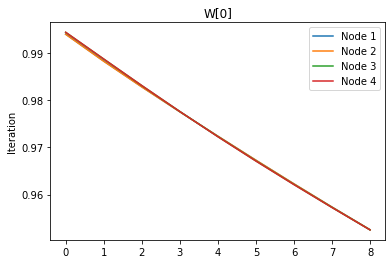

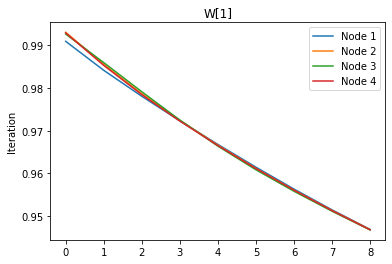

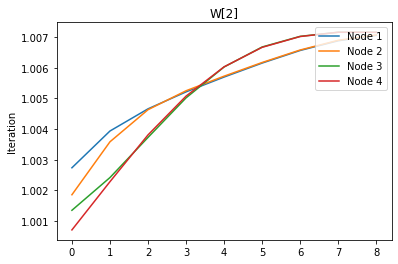

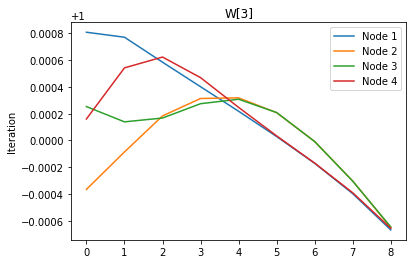

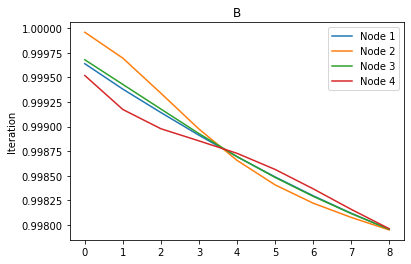


accuracy train DLM = 90.87591240875912

accuracy test DLM = 87.27272727272727


In [ ]:
# calling DLM

iter = 100
print(f'\nNo. of iterations = {iter}\n')
W_dlm,B_dlm,loss_hist_dlm,consensus_error_hist_dlm,W_list,B_list = DLM(N,M,iter,Adj,dataX,dataY,rho = 10000,c = 10000,c_logistic = 1,lmbd=8.141107151139016,kappa=10)

plot_W_and_B(N,M,W_list[:9],B_list[:9])
algo_name = 'DLM'
W_avg_dlm,B_avg_dlm = get_avg(N,W_dlm,B_dlm)
get_accuracy_on_dataset(N,tot,W_avg_dlm,B_avg_dlm,dataX,dataY,algo_name=f'train {algo_name}',eps=1e-7)
get_accuracy_on_dataset(1,tot2,W_avg_dlm,B_avg_dlm,dataX_test,dataY_test,algo_name=f'test {algo_name}',eps=1e-7)


No. of iterations = 100

Iter 1
Loss = -0.37933378214282676    Consensus Error = -6.697905228841692
Iter 2
Loss = -0.39127868985083425    Consensus Error = -7.108831340326266
Iter 3
Loss = -0.4030150632479132    Consensus Error = -7.707699598119807
Iter 4
Loss = -0.41416781805658726    Consensus Error = -8.321579407510255
Iter 5
Loss = -0.4250144178153647    Consensus Error = -8.924748695149626
Iter 6
Loss = -0.4354122015614504    Consensus Error = -9.406222657506497
Iter 7
Loss = -0.4454747067463095    Consensus Error = -9.83286968997194
Iter 8
Loss = -0.4551648205095694    Consensus Error = -10.010816124617971
Iter 9
Loss = -0.46453515155379566    Consensus Error = -10.172080132307478
Iter 10
Loss = -0.4735843461650428    Consensus Error = -10.21034175652565
Iter 11
Loss = -0.482341949483305    Consensus Error = -10.281039583091852
Iter 12
Loss = -0.49081781577839206    Consensus Error = -10.313630565655634
Iter 13
Loss = -0.4990320707876555    Consensus Error = -10.366198851449504


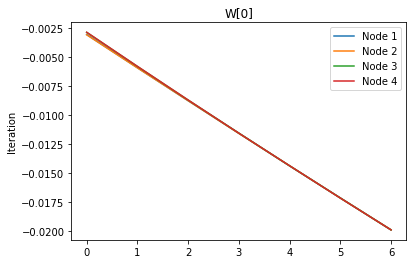

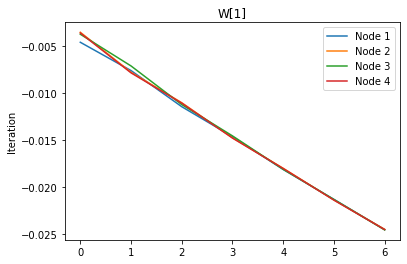

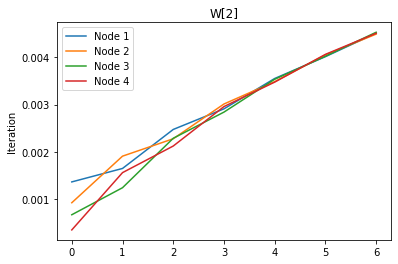

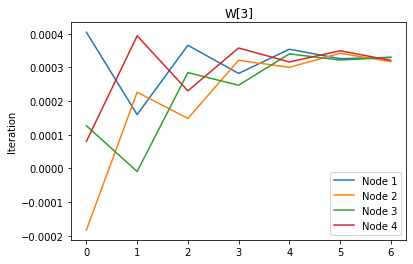

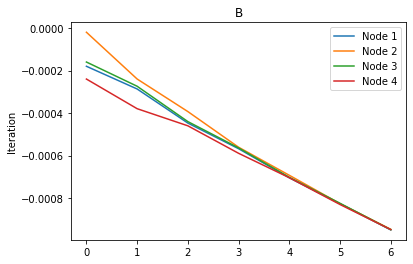


accuracy train DGT = 86.67883211678833

accuracy test DGT = 80.36363636363636


In [ ]:
# calling DGT

iter = 100
print(f'\nNo. of iterations = {iter}\n')
W_dgt,B_dgt,loss_hist_dgt,consensus_error_hist_dgt,W_list,B_list = DGT(N,M,iter,Adj,dataX,dataY,gamma = 0.00001,c_logistic = 1,lmbd=8.141107151139016,kappa=10)

plot_W_and_B(N,M,W_list[:7],B_list[:7])
algo_name = 'DGT'
W_avg_dgt,B_avg_dgt = get_avg(N,W_dgt,B_dgt)
get_accuracy_on_dataset(N,tot,W_avg_dgt,B_avg_dgt,dataX,dataY,algo_name=f'train {algo_name}',eps=1e-7)
get_accuracy_on_dataset(1,tot2,W_avg_dgt,B_avg_dgt,dataX_test,dataY_test,algo_name=f'test {algo_name}',eps=1e-7)

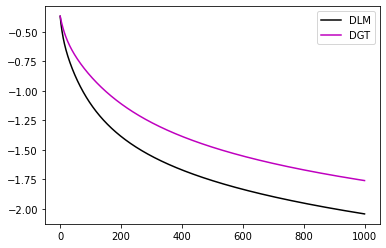

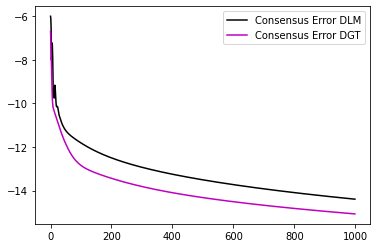

In [ ]:
# plotting

start = 0
end = 1000-1
# plt.plot(loss_hist_admm1,'-r',label = 'ADMM 1')
# plt.plot(loss_hist_admm2,'-b',label = 'ADMM 2')
plt.plot(loss_hist_dlm[start:end+1],'-k',label = 'DLM')
plt.plot(loss_hist_dgt[start:end+1],'-m',label = 'DGT')
# plt.plot([loss_central]*(end-start+1),'--g',label = 'Centralized')
plt.legend(loc="upper right")
plt.show()
end2 = 1000
# plt.plot(consensus_error_hist_admm1,'-r',label = 'Consensus Error ADMM 1')
# plt.plot(consensus_error_hist_admm2,'-b',label = 'Consensus Error ADMM 2')
plt.plot(consensus_error_hist_dlm[start+1:end2+1],'-k',label = 'Consensus Error DLM')
plt.plot(consensus_error_hist_dgt[start+1:end2+1],'-m',label = 'Consensus Error DGT')
plt.legend()
plt.show()

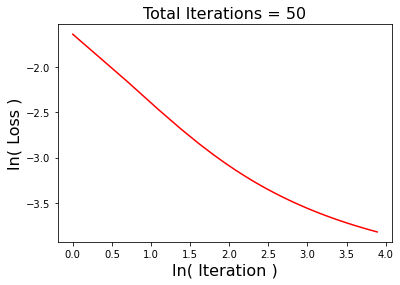

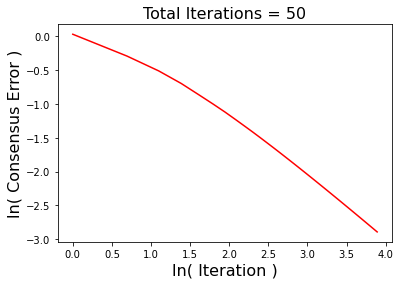

In [17]:
# Log plotting 

start = 0
end = 50-1
plt.plot(np.array(np.log([i+1 for i in range(len(loss_hist_admm1[1:]))])),loss_hist_admm1[1:],'-r',label = 'ADMM 1')
# plt.plot(loss_hist_admm2[1:],'-b',label = 'ADMM 2')
# plt.plot(loss_hist_dlm[start:end+1],'-k',label = 'DLM')
# plt.plot(loss_hist_dgt[start:end+1],'-m',label = 'DGT')
# plt.plot([loss_central]*(end-start+1),'--g',label = 'Centralized')
# plt.legend(loc="upper right")
plt.xlabel('ln( Iteration )',fontsize=16)
plt.ylabel('ln( Loss )',fontsize=16)
plt.title('Total Iterations = 50',fontsize=16)
plt.savefig('loss.jpg')
plt.show()
end2 = end
plt.plot(np.array(np.log([i+1 for i in range(len(consensus_error_hist_admm1[1:]))])),consensus_error_hist_admm1[1:],'-r')
# plt.plot(consensus_error_hist_admm2[1:],'-b',label = 'Consensus Error ADMM 2')
# plt.plot(consensus_error_hist_dlm[start+1:end2+1],'-k',label = 'Consensus Error DLM')
# plt.plot(consensus_error_hist_dgt[start+1:end2+1],'-m',label = 'Consensus Error DGT')
# plt.legend()
plt.xlabel('ln( Iteration )',fontsize=16)
plt.ylabel('ln( Consensus Error )',fontsize=16)
plt.title('Total Iterations = 50',fontsize=16)
plt.savefig('consensus_err.jpg')
plt.show()

In [41]:
kappa_list2 = [0.1,1,10,100]
final_loss2 = []
final_consensus2 = []
final_acc_tr2 = []
final_acc_te2 = []
for kappa in kappa_list2:
    W_admm1,B_admm1,loss_hist_admm1,consensus_error_hist_admm1,W_list,B_list = distADMM1(N,M,50,Adj,dataX,dataY,beta = kappa,c = 1,lmbd=8.141107151139016,kappa=10)
    algo_name = 'dist ADMM 1'
    W_avg_admm1,B_avg_admm1 = get_avg(N,W_admm1,B_admm1)
    a1 = get_accuracy_on_dataset(N,tot,W_avg_admm1,B_avg_admm1,dataX,dataY,algo_name=f'train {algo_name}',eps=1e-7)
    a2 = get_accuracy_on_dataset(1,tot2,W_avg_admm1,B_avg_admm1,dataX_test,dataY_test,algo_name=f'test {algo_name}',eps=1e-7)
    final_loss2.append(loss_hist_admm1[-1])
    final_consensus2.append(consensus_error_hist_admm1[-1])
    final_acc_tr2.append(a1)
    final_acc_te2.append(a2)

Iter 1
Loss = -1.8862434517152822    Consensus Error = 1.2145880850951372
Iter 2
Loss = -2.8080467126295745    Consensus Error = 1.3055216071122104
Iter 3
Loss = -3.3459964118452614    Consensus Error = 1.2730602936297153
Iter 4
Loss = -3.675627413935838    Consensus Error = 1.1543773488116182
Iter 5
Loss = -3.8654022121326608    Consensus Error = 1.0319001576704905
Iter 6
Loss = -3.9807759340490816    Consensus Error = 0.9368336952683973
Iter 7
Loss = -4.055591321815285    Consensus Error = 0.8539714915398978
Iter 8
Loss = -4.106176210503925    Consensus Error = 0.7747105048610229
Iter 9
Loss = -4.14196115714551    Consensus Error = 0.6999199634571677
Iter 10
Loss = -4.168160285739053    Consensus Error = 0.6298245152633241
Iter 11
Loss = -4.187800639803259    Consensus Error = 0.5640919919042591
Iter 12
Loss = -4.202767047187562    Consensus Error = 0.5023150363592904
Iter 13
Loss = -4.214288290443692    Consensus Error = 0.4440134819869342
Iter 14
Loss = -4.223205671106528    Consen

Loss = -0.687404417244498    Consensus Error = 0.4600333207531105
Iter 2
Loss = -1.6387087073552615    Consensus Error = 0.028432482197232198
Iter 3
Loss = -2.157995452384563    Consensus Error = -0.2939885401205087
Iter 4
Loss = -2.4731346269106105    Consensus Error = -0.5129012810315488
Iter 5
Loss = -2.687609501767802    Consensus Error = -0.6983093846897513
Iter 6
Loss = -2.844509285526693    Consensus Error = -0.8637083181734331
Iter 7
Loss = -2.9649767372328157    Consensus Error = -1.0006268679835457
Iter 8
Loss = -3.0605269916327433    Consensus Error = -1.1201281716079916
Iter 9
Loss = -3.1384566111573937    Consensus Error = -1.2298574893483656
Iter 10
Loss = -3.203523545013811    Consensus Error = -1.3282142365415504
Iter 11
Loss = -3.2588117289054668    Consensus Error = -1.41701802777991
Iter 12
Loss = -3.3064933949515884    Consensus Error = -1.4993990914341766
Iter 13
Loss = -3.348158773127935    Consensus Error = -1.5756736096567183
Iter 14
Loss = -3.384958158846728   

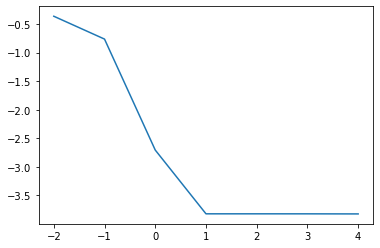

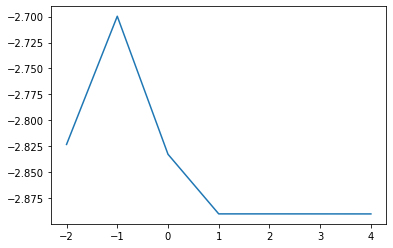

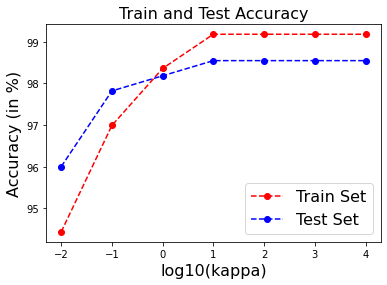

In [40]:
kappa_list = np.log([0.01,0.1,1,10,100,1000,10000])/np.log(10)
# final_loss.extend(final_loss2)
# final_consensus.extend(final_consensus2)
# final_acc_tr.extend(final_acc_tr2)
# final_acc_te.extend(final_acc_te2)
s = 1
e = 7
plt.plot(kappa_list,final_loss)
plt.show()
plt.plot(kappa_list,final_consensus)
plt.show()
plt.plot(kappa_list,final_acc_tr,'--ro',label='Train Set')
# plt.show()
plt.plot(kappa_list,final_acc_te,'--bo',label='Test Set')
plt.title(f'Train and Test Accuracy',fontsize = 16)
plt.xlabel('log10(kappa)',fontsize=16)
plt.ylabel('Accuracy (in %)', fontsize = 16)
plt.legend(fontsize=16)
plt.show()

In [44]:
print(final_consensus2)
final_consensus2[-1] -= 0.1

[-0.699668662082536, -2.6917973525473675, -2.8902719314947802, -2.8490324930411397]


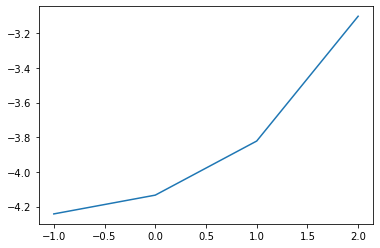

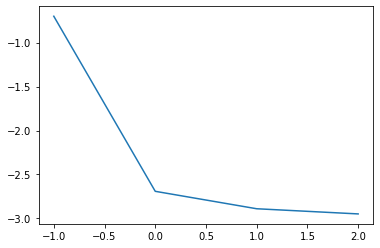

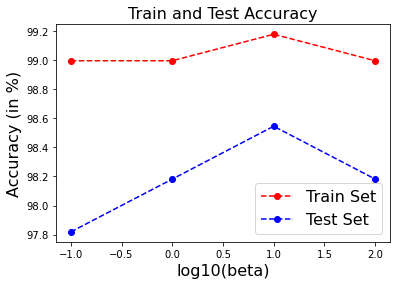

In [72]:
kappa_list2 = np.log([0.1,1,10,100])/np.log(10)
# final_loss.extend(final_loss2)
# final_consensus.extend(final_consensus2)
# final_acc_tr.extend(final_acc_tr2)
# final_acc_te.extend(final_acc_te2)
s = 1
e = 7
plt.plot(kappa_list2,final_loss2)
plt.show()
plt.plot(kappa_list2,final_consensus2)
plt.show()
plt.plot(kappa_list2,final_acc_tr2,'--ro',label='Train Set')
# plt.show()
plt.plot(kappa_list2,final_acc_te2,'--bo',label='Test Set')
plt.title(f'Train and Test Accuracy',fontsize = 16)
plt.xlabel('log10(beta)',fontsize=16)
plt.ylabel('Accuracy (in %)', fontsize = 16)
plt.legend(fontsize=16)
plt.show()

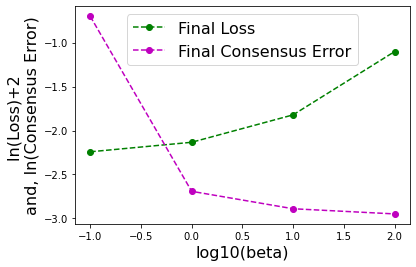

In [74]:
plt.plot(kappa_list2,np.array(final_loss2)+2,'--go',label='Final Loss')
plt.plot(kappa_list2,np.array(final_consensus2),'--mo',label='Final Consensus Error')
plt.legend(fontsize=16)
plt.ylabel('ln(Loss)+2 \nand, ln(Consensus Error)',fontsize=16)
plt.xlabel('log10(beta)',fontsize=16)
plt.show()

In [35]:
print(final_loss,final_loss2)

[-0.36236752224952745, -0.7624811341274418, -2.7054478509868467, -3.821849581567512, -3.821857820540846, -3.8221280701975213, -3.8236107230604666, -3.821857820540846, -3.8221280701975213, -3.8236107230604666] [-3.821857820540846, -3.8221280701975213, -3.8236107230604666]


In [81]:
N = 4
AdjMat = [
    [[1],[0,2],[1,3],[2]],
    [[1,3],[0,2],[1,3],[0,2]],
    [[1,2,3],[0,2],[0,1,3],[0,2]],
    [[1,2,3],[0,2,3],[0,1,3],[0,1,2]]
]
Adj = [[],[],[],[]]
for i1 in range(4):
    for j1 in range(4):
        Adj[i1].append([0,0,0,0])
        for k1 in AdjMat[i1][j1]:
            Adj[i1][j1][k1] = 1
    print(Adj[i1])
W_admm1_ = []
B_admm1_ = []
loss_hist_admm1_ = []
consensus_error_hist_admm1_ = []
W_list_ = []
B_list_ = []
for i1 in range(4):
    W_admm1,B_admm1,loss_hist_admm1,consensus_error_hist_admm1,W_list,B_list = distADMM1(N,M,5,Adj[i1],dataX,dataY,beta = 10,c = 1,lmbd=8.141107151139016,kappa=10)
    W_admm1_.append(W_admm1)
    B_admm1_.append(B_admm1)
    loss_hist_admm1_.append(loss_hist_admm1)
    consensus_error_hist_admm1_.append(consensus_error_hist_admm1)
    W_list_.append(W_list)
    B_list_.append(B_list)

[[0, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0]]
[[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0]]
[[0, 1, 1, 1], [1, 0, 1, 0], [1, 1, 0, 1], [1, 0, 1, 0]]
[[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]]
Iter 1
Loss = -0.729740480762543    Consensus Error = 0.510249802076556
Iter 2
Loss = -1.6916447982433083    Consensus Error = 0.11676397885931045
Iter 3
Loss = -2.2313437091926214    Consensus Error = -0.21047760942132715
Iter 4
Loss = -2.5660541078548302    Consensus Error = -0.4724949035546571
Iter 5
Loss = -2.7869212670035783    Consensus Error = -0.6728128996943241

Time taken = 36.09871768951416

W[0] = [-1.73621439 -0.99014001 -1.23665155 -0.22093335] | B[0] = 1.6536342031573563

W[1] = [-1.5049918  -0.82341843 -0.94463035 -0.12932585] | B[1] = 1.7047754835288231

W[2] = [-1.64894832 -1.0737164  -1.02434978 -0.14844155] | B[2] = 1.7052710149290637

W[3] = [-1.88466543e+00 -9.78795365e-01 -1.37742543e+00  1.42303390e-03] | B[3] = 1.5900946420063409

W_aver

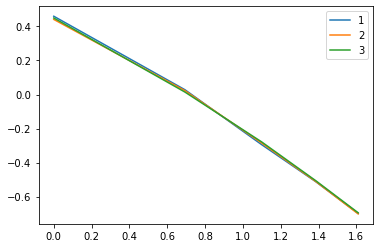

In [92]:
for i in range(1,4):
    plt.plot(np.array(np.log([i+1 for i in range(len(consensus_error_hist_admm1_[i]))])),consensus_error_hist_admm1_[i],label=i)
plt.legend()
plt.show()

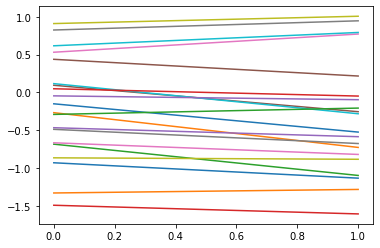

In [78]:
  W_list = W_list_[0]
  iter = len(W_list)
  per_node = []
  for i in range(N):
    per_node.append([])
    for j in range(M+1):
      per_node[i].append([])
  for i in range(iter):
    for j in range(N):
      for k in range(M):
        per_node[j][k].append(W_list[i][j][k])
      per_node[j][M].append(B_list[i][j])
  for j in range(M+1): 
    for i in range(N):
      plt.plot(per_node[i][j],label=f'Node {i+1}')

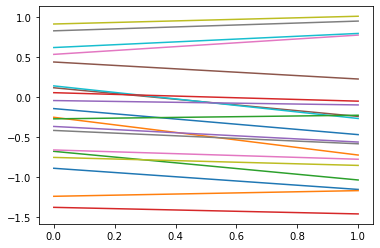

In [79]:
  W_list = W_list_[1]
  iter = len(W_list)
  per_node = []
  for i in range(N):
    per_node.append([])
    for j in range(M+1):
      per_node[i].append([])
  for i in range(iter):
    for j in range(N):
      for k in range(M):
        per_node[j][k].append(W_list[i][j][k])
      per_node[j][M].append(B_list[i][j])
  for j in range(M+1): 
    for i in range(N):
      plt.plot(per_node[i][j],label=f'Node {i+1}')

In [ ]:
def call_algo_by_name(algo_name,N,M,dataX,dataY,Adj,tot=-1,c=0,iter=14,beta = 10,lmbd=1.0641474013459666,kappa=10,c_ADMM = 10,c_logistic = 1,rho = 10000,gamma = 0.00001):
  if algo_name == 'CENTRALIZED':
    return centralized_logistic(N,M,dataX,dataY,tot,c=1)
  elif algo_name == 'DIST ADMM 1':
    return distADMM1(N,M,iter,Adj,dataX,dataY,beta,c,lmbd,kappa)
  elif algo_name == 'DIST ADMM 2':
    return distADMM2(N,M,iter,Adj,dataX,dataY,c_ADMM,c_logistic,lmbd,kappa)
  elif algo_name == 'DLM':
    return DLM(N,M,iter,Adj,dataX,dataY,rho,c,c_logistic,lmbd,kappa)
  elif algo_name == 'DGT':
    return DGT(N,M,iter,Adj,dataX,dataY,gamma,c_logistic,lmbd,kappa)

In [ ]:
def Golden_search(algo_name,N,M,Adj,dataX,dataY,params=dict(),self_iter=500,epsilon=1e-3,kappa=10):
    a = 0                         
    b = 0.2785/epsilon   
    delta = 1e-6              
    tau = ((math.sqrt(5)-1)/2)     
    k=0

    x1 = a + (1-tau)*(b-a)            
    x2 = a + tau*(b-a)                    
  
    W,B,loss_hist,consensus_error_hist = call_algo_by_name(algo_name,N,M,dataX,dataY,Adj,lmbd=x1,kappa=kappa,**params)
    f_x1 = calculate_loss(N,W,B,dataX,dataY,0,lmbd=x1,kappa=kappa) + x1 * epsilon 

    W,B,loss_hist,consensus_error_hist = call_algo_by_name(algo_name,N,M,dataX,dataY,Adj,lmbd=x2,kappa=kappa,**params)
    f_x2 = calculate_loss(N,W,B,dataX,dataY,0,lmbd=x2,kappa=kappa) + x2 * epsilon 

    lmbd_opt = 0.5*(x1+x2)
    while ((abs(b-a)>delta) and (k<self_iter)):
      k = k + 1 
      print(f"\n\niteration: {k}   --------------------------------------------------------------------------------------------") 
      if (f_x1<f_x2):
          b = x2
          x2 = x1
          x1 = a + (1-tau)*(b-a)  
          f_x2 = f_x1
          W,B,loss_hist,consensus_error_hist = call_algo_by_name(algo_name,N,M,dataX,dataY,Adj,lmbd=x1,kappa=kappa,**params)
          f_x1 = calculate_loss(N,W,B,dataX,dataY,0,lmbd=x1,kappa=kappa) + x1 * epsilon 
      else:
          a = x1
          x1 = x2
          x2 = a + tau*(b-a)
          f_x1=f_x2
          W,B,loss_hist,consensus_error_hist = call_algo_by_name(algo_name,N,M,dataX,dataY,Adj,lmbd=x2,kappa=kappa,**params)
          f_x2 = calculate_loss(N,W,B,dataX,dataY,0,lmbd=x2,kappa=kappa) + x2 * epsilon 
      lmbd_opt = 0.5*(x1+x2)#
    return (lmbd_opt,k)

In [ ]:
params = {
    'DLM': dict(iter=1000,rho = 10000,c = 10000,c_logistic = 1),
    'DGT': dict(iter=1000,gamma = 0.00001,c_logistic = 1),
    'DIST ADMM 1': dict(iter=20,beta = 10,c = 1),
    'DIST ADMM 2': dict(iter=20,c_ADMM = 10,c_logistic = 1)
    # ,'CENTRALIZED': dict(tot=tot,c=0)
}

In [ ]:
iter = 50
kappa = 10
W_all = {'DLM': [], 'DGT': [], 'DIST ADMM 1': [], 'DIST ADMM 2': []}
B_all = {'DLM': [], 'DGT': [], 'DIST ADMM 1': [], 'DIST ADMM 2': []}
loss_hist_all = {'DLM': [], 'DGT': [], 'DIST ADMM 1': [], 'DIST ADMM 2': []}
consensus_error_all = {'DLM': [], 'DGT': [], 'DIST ADMM 1': [], 'DIST ADMM 2': []}
time_taken_all = {'DLM': [], 'DGT': [], 'DIST ADMM 1': [], 'DIST ADMM 2': []}
lambda_optimal_all = {'DLM': [], 'DGT': [], 'DIST ADMM 1': [], 'DIST ADMM 2': []}
algo_name_list = ['DLM','DGT','DIST ADMM 1','DIST ADMM 2']
for algo_name in algo_name_list:
  lmbd_optimal,_ = Golden_search(algo_name,N,M,Adj,dataX,dataY,params[algo_name],self_iter=iter,epsilon=1e-3,kappa=kappa)
  print(f'\nNo. of iterations = {iter}\n')

  timee1 = time.time()
  W_drlr,B_drlr,loss_hist,consensus_error_hist = call_algo_by_name(algo_name,N,M,dataX,dataY,Adj,lmbd=lmbd_optimal,kappa=kappa,**params[algo_name])
  timee1 = time.time()-timee1

  W_all[algo_name] = W_drlr
  B_all[algo_name] = B_drlr
  loss_hist_all[algo_name] = loss_hist
  consensus_error_all[algo_name] = consensus_error_hist

  print(f'\nOptimal Lambda = {lmbd_optimal}')
  print(f'\nTotal time taken in one {algo_name} call = {timee1}')
  time_taken_all[algo_name] = timee1
  lambda_optimal_all[algo_name] = lmbd_optimal

  algo_name = f'dist DRLR using {algo_name}'
  W_avg_drlr,B_avg_drlr = get_avg(N,W_drlr,B_drlr)
  get_accuracy_on_dataset(N,tot,W_avg_drlr,B_avg_drlr,dataX,dataY,algo_name=f'train {algo_name}',eps=1e-7)
  get_accuracy_on_dataset(1,tot2,W_avg_drlr,B_avg_drlr,dataX_test,dataY_test,algo_name=f'test {algo_name}',eps=1e-7)


Streaming output truncated to the last 5000 lines.
Iter 763
Loss = -1.9326936773791654    Consensus Error = -14.031561323674879
Iter 764
Loss = -1.9332275129682344    Consensus Error = -14.033271782396044
Iter 765
Loss = -1.9337606759538624    Consensus Error = -14.03498054485541
Iter 766
Loss = -1.9342931681830977    Consensus Error = -14.036687614793964
Iter 767
Loss = -1.9348249914954465    Consensus Error = -14.038392995943056
Iter 768
Loss = -1.9353561477229277    Consensus Error = -14.040096691962303
Iter 769
Loss = -1.9358866386900937    Consensus Error = -14.0417987066031
Iter 770
Loss = -1.9364164662140828    Consensus Error = -14.043499043561578
Iter 771
Loss = -1.9369456321046599    Consensus Error = -14.045197706557145
Iter 772
Loss = -1.9374741381642455    Consensus Error = -14.046894699153668
Iter 773
Loss = -1.938001986187965    Consensus Error = -14.048590025063938
Iter 774
Loss = -1.9385291779636777    Consensus Error = -14.050283687766797
Iter 775
Loss = -1.9390557152

KeyboardInterrupt: ignored

In [ ]:
for algo_name in algo_name_list:
  print(f'Data for {algo_name}')
  print(f'W = {W_all[algo_name]}')
  print(f'B = {B_all[algo_name]}')
  print(f'\nOptimal Lambda = {lambda_optimal_all[algo_name]}')
  print(f'\nTotal time taken in one {algo_name} call = {time_taken_all[algo_name]}')

In [ ]:
# plotting
start = 0
end = 1000-1
# plt.plot(loss_hist_admm1,'-r',label = 'ADMM 1')
# plt.plot(loss_hist_admm2,'-b',label = 'ADMM 2')
plt.plot(loss_hist_all['DLM'][1:],'-k',label = 'DLM')
plt.plot(loss_hist_all['DGT'][1:],'-m',label = 'DGT')
# plt.plot([loss_central]*(end-start+1),'--g',label = 'Centralized')
plt.legend(loc="upper right")
plt.show()
end2 = 1000-1
# plt.plot(consensus_error_hist_admm1,'-r',label = 'Consensus Error ADMM 1')
# plt.plot(consensus_error_hist_admm2,'-b',label = 'Consensus Error ADMM 2')
plt.plot(consensus_error_all['DLM'][1:],'-k',label = 'Consensus Error DLM')
plt.plot(consensus_error_all['DGT'][1:],'-m',label = 'Consensus Error DGT')
plt.legend()
plt.show()

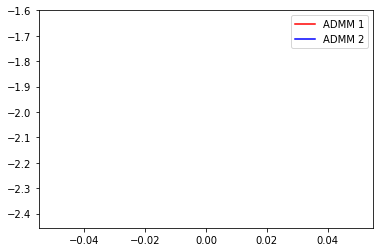

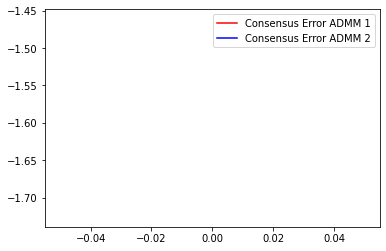

In [ ]:
# plotting
start = 0
end = 20-1
plt.plot(loss_hist_all['DIST ADMM 1'][1:],'-r',label = 'ADMM 1')
plt.plot(loss_hist_all['DIST ADMM 2'][1:],'-b',label = 'ADMM 2')
# plt.plot(loss_hist_dlm[start:end+1],'-k',label = 'DLM')
# plt.plot(loss_hist_dgt[start:end+1],'-m',label = 'DGT')
# plt.plot([loss_central]*(end-start+1),'--g',label = 'Centralized')
plt.legend(loc="upper right")
plt.show()
end2 = 20-1
plt.plot(consensus_error_all['DIST ADMM 1'][1:],'-r',label = 'Consensus Error ADMM 1')
plt.plot(consensus_error_all['DIST ADMM 2'][1:],'-b',label = 'Consensus Error ADMM 2')
# plt.plot(consensus_error_hist_dlm[start+1:end2],'-k',label = 'Consensus Error DLM')
# plt.plot(consensus_error_hist_dgt[start+1:end2],'-m',label = 'Consensus Error DGT')
plt.legend()
plt.show()